In [54]:
import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
np.random.seed(11)

C = 30
T = 60
P_MIN, P_MAX, N_PRICES = 40.0, 320.0, 81
PRICE_GRID = np.linspace(P_MIN, P_MAX, N_PRICES)

A = 28.0
s = (np.arange(1, T+1) / T) ** 1.6
s = s / s.sum()

             
alpha_pois = A * s 
lam_bern  = 1 - np.exp(-alpha_pois) 
def _calibrate_k_for_sum(A_target, s, max_iter=60): # calibrates bernoulli so that expectations are equal
    # Solve sum(1 - exp(-k s_i)) = A_target via bisection
    def tot(k): return float(np.sum(1 - np.exp(-k * s)))
    if A_target > len(s):  # infeasible (λ_t <= 1)
        raise ValueError("Target exceeds T; cannot match with Bernoulli")
    lo, hi = 0.0, 1.0
    while tot(hi) < A_target:
        hi *= 2
    for _ in range(max_iter):
        mid = (lo + hi) / 2
        if tot(mid) >= A_target: hi = mid
        else: lo = mid
    return hi

k = _calibrate_k_for_sum(A, s)
lam_bern = 1 - np.exp(-k * s)

print(lam_bern.sum(), alpha_pois.sum()) 


28.000000000000004 28.0


In [55]:
def S_logistic(p, t, T, mu0=120.0, mu1=220.0, beta=22.0):
    mu = mu0 + (mu1 - mu0)*(1 - t/T)
    return 1.0/(1.0 + math.exp((p - mu)/beta))

def sample_logistic(t, T, size=None, mu0= 120.0, mu1 =220.0, beta=22.0):
    mu = mu0 + (mu1 - mu0)*(1 - t/T)
    n = 1 if size is None else size
    u = np.random.rand(n)
    w = mu + beta*np.log(u/(1-u))
    return w if size is not None else float(w[0])

def S_lognormal(p, t, T, m0=4.7, s0=0.35, m1=5.3, s1=0.28):
    if p<=0: return 1.0
    w = 1 - t/T
    m = (1-w)*m0 + w*m1
    s = (1-w)*s0 + w*s1
    z = (math.log(p) - m)/s
    return 1 - 0.5*(1 + math.erf(z/np.sqrt(2)))

def sample_lognormal(t, T, size=None, m0=4.7, s0=0.35, m1=5.3, s1=0.28):
    w = 1 - t/T
    m = (1-w)*m0 + w*m1
    s = (1-w)*s0 + w*s1
    return np.random.lognormal(mean=m, sigma=s, size=size)

def S_mixture_lb(p, t, T,
                 pi_early=0.75, pi_late=0.25,
                 muL=130.0, betaL=28.0,
                 muB=210.0, betaB=20.0):
    pi = pi_early*(t/T) + pi_late*(1 - t/T)
    SL = 1.0/(1.0 + math.exp((p - muL)/betaL))
    SB = 1.0/(1.0 + math.exp((p - muB)/betaB))
    return pi*SL + (1-pi)*SB

def sample_mixture_lb(t, T,
                      pi_early=0.75, pi_late=0.25,
                      muL=130.0, betaL=28.0,
                      muB=210.0, betaB=20.0,
                      size=None):
    pi = pi_early*(t/T) + pi_late*(1 - t/T)
    n = 1 if size is None else size
    chooseB = np.random.rand(n) > pi
    u = np.random.rand(n)
    w = np.empty(n)
    w[~chooseB] = muL + betaL*np.log(u[~chooseB]/(1-u[~chooseB]))
    w[ chooseB] = muB + betaB*np.log(u[ chooseB]/(1-u[ chooseB]))
    return w if size is not None else float(w[0])



In [56]:
def solve_dp(C, T, price_grid, arrival_kind, arrival_seq, surv_fn):
    V = np.zeros((T+1, C+1))
    Pstar = np.zeros((T+1, C+1))
    for t in range(1, T+1):
        if arrival_kind=="bernoulli":
            lam = float(arrival_seq[t-1])
        elif arrival_kind=="poisson":
            lam = None
            alpha = float(arrival_seq[t-1])
        for c in range(1, C+1):
            Vtm1c, Vtm1c1 = V[t-1, c], V[t-1, c-1]
            best, bp = -1e18, price_grid[0]
            for p in price_grid:
                S = surv_fn(p, t, T)
                if arrival_kind=="bernoulli":
                    val = (1-lam)*Vtm1c + lam*( S*(p+Vtm1c1) + (1-S)*Vtm1c )
                else:
                    rate = alpha
                    kmax = int(max(15, math.ceil(rate + 8*math.sqrt(rate+1e-9))))
                    pmf = [math.exp(-rate)]
                    for k in range(1, kmax+1):
                        pmf.append(pmf[-1]*rate/k)
                    val = 0.0
                    for k,pk in enumerate(pmf):
                        if pk<1e-12: continue
                        q = S
                        yy_prob = [math.comb(k,y)*(q**y)*((1-q)**(k-y)) for y in range(k+1)]
                        for y,py in enumerate(yy_prob):
                            x = y if y<=c else c
                            val += pk*py*( x*p + V[t-1, c-x] )
                if val>best:
                    best, bp = val, p
            V[t,c], Pstar[t,c] = best, bp
    return V, Pstar



In [57]:
wtp_defs = {
    "Logistic": (S_logistic, sample_logistic, r"Shifted logistic: $S_t(p)=\frac{1}{1+e^{(p-\mu_t)/\beta}}$"),
    "Lognormal": (S_lognormal, sample_lognormal, r"Lognormal: $W\sim \exp(\mathcal N(m_t,s_t^2))$"),
    "MixtureLB": (S_mixture_lb, sample_mixture_lb, r"Mixture: $S_t=\pi_t S_L+(1-\pi_t)S_B$"),
}

scenarios = {}
for wname,(S,Sampler,desc) in wtp_defs.items():
    scenarios[("Bernoulli", wname)] = dict(kind="bernoulli", arr=lam_bern, S=S, Sampler=Sampler, desc=desc)
    scenarios[("Poisson", wname)]   = dict(kind="poisson",   arr=alpha_pois, S=S, Sampler=Sampler, desc=desc)

solns = {}
for key,sc in scenarios.items():
    V,P = solve_dp(C, T, PRICE_GRID, sc["kind"], sc["arr"], sc["S"])
    solns[key] = dict(V=V, P=P)
list(solns.keys())


[('Bernoulli', 'Logistic'),
 ('Poisson', 'Logistic'),
 ('Bernoulli', 'Lognormal'),
 ('Poisson', 'Lognormal'),
 ('Bernoulli', 'MixtureLB'),
 ('Poisson', 'MixtureLB')]

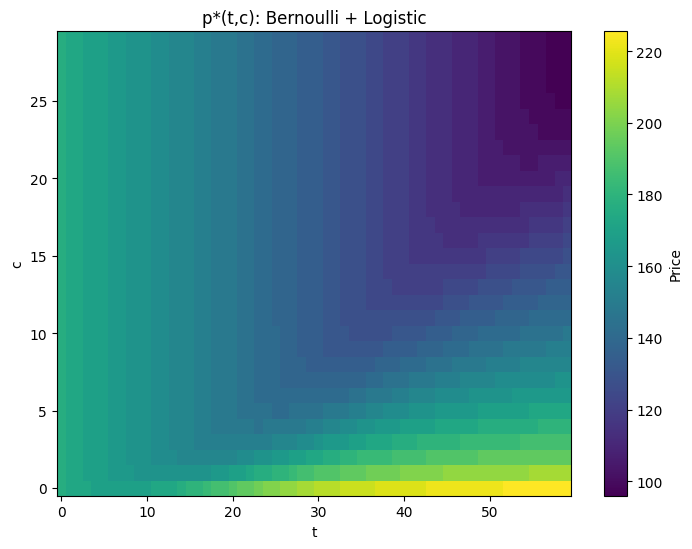

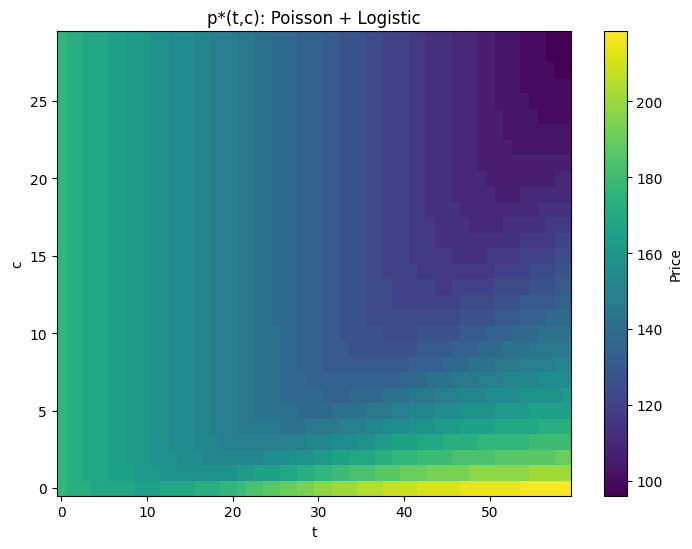

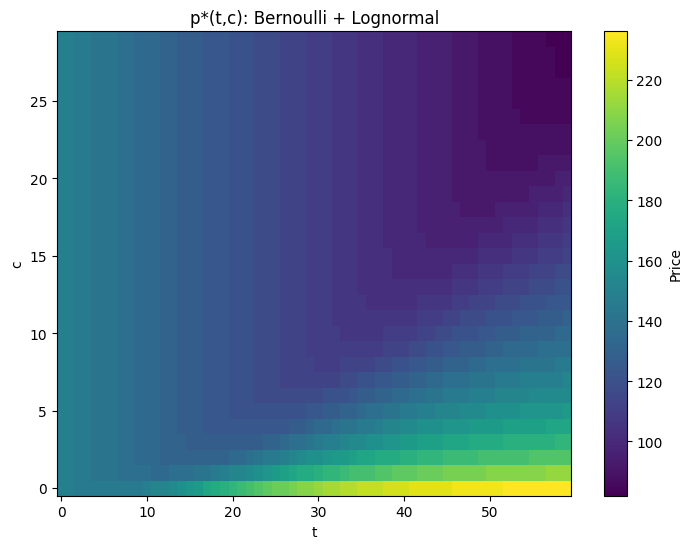

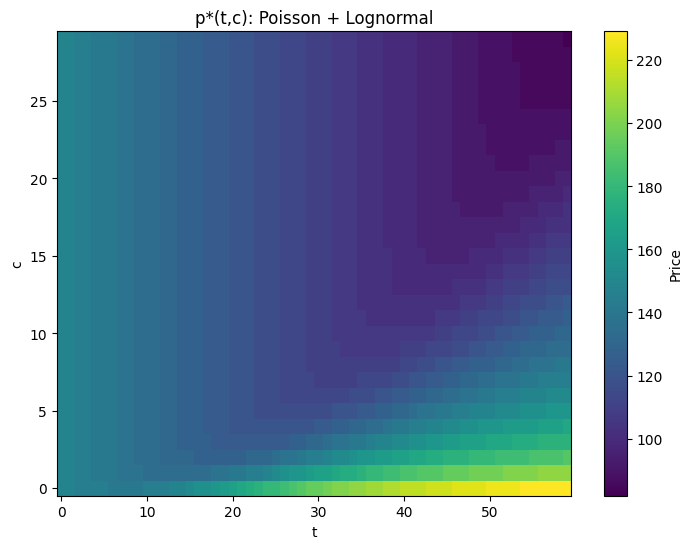

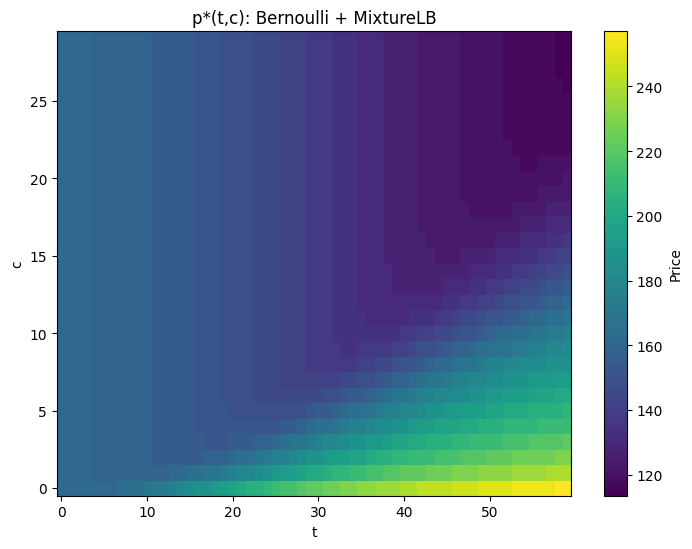

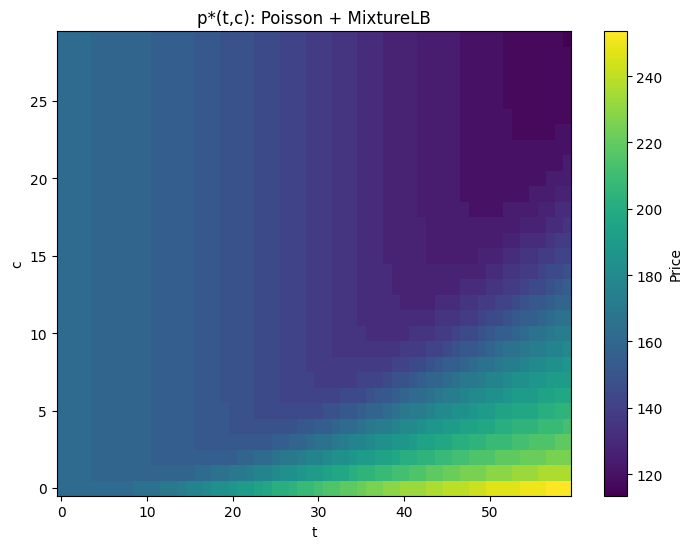

In [58]:
for (ak, wname),res in solns.items():
    plt.figure(figsize=(7.2,5.6))
    plt.imshow(res["P"][1:,1:].T, aspect='auto', origin='lower')
    plt.xlabel("t")
    plt.ylabel("c")
    plt.title(f"p*(t,c): {ak} + {wname}")
    plt.colorbar(label="Price")
    plt.tight_layout()
    plt.show()

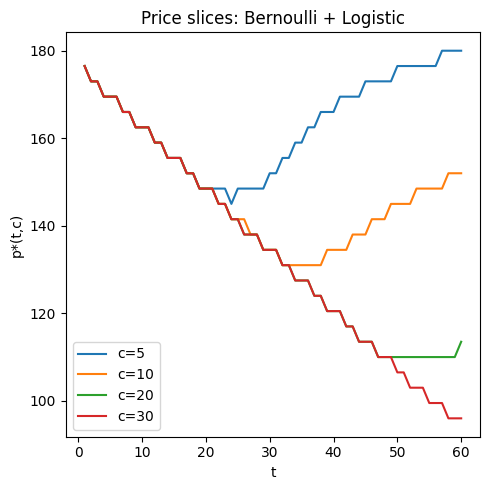

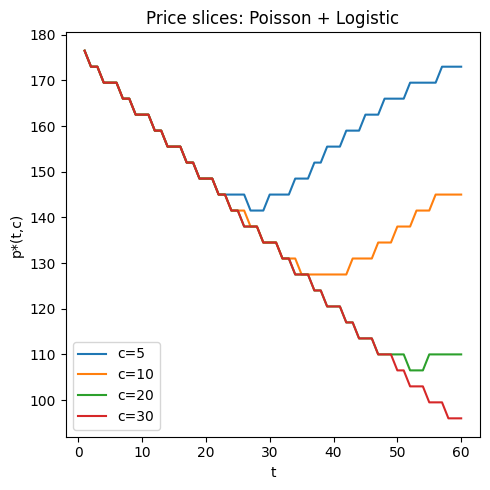

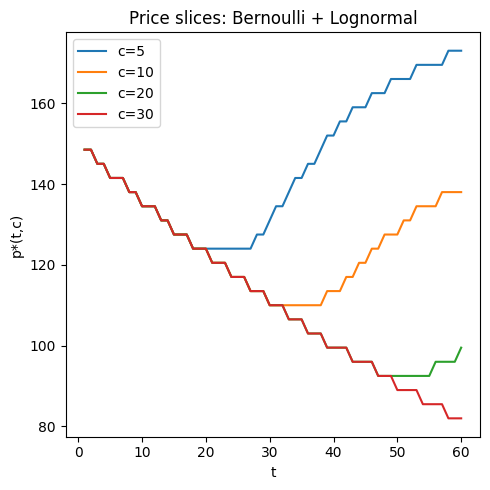

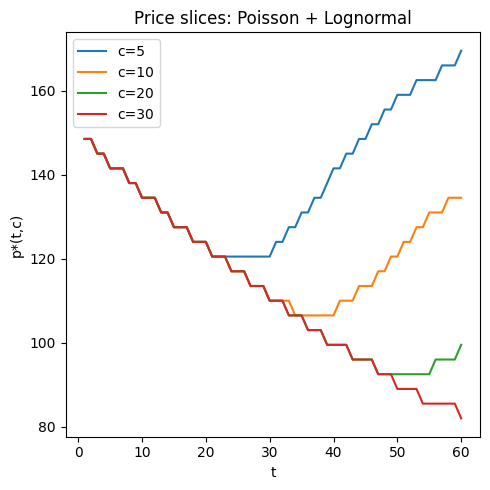

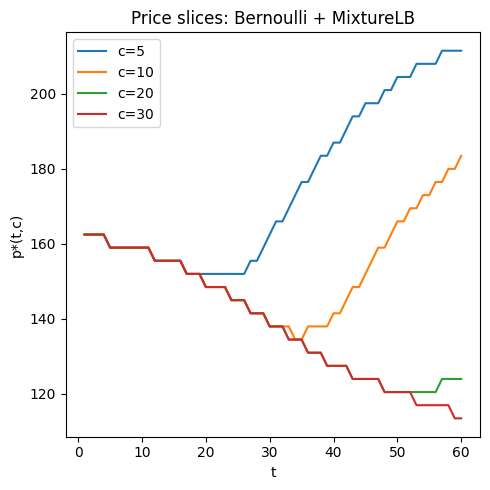

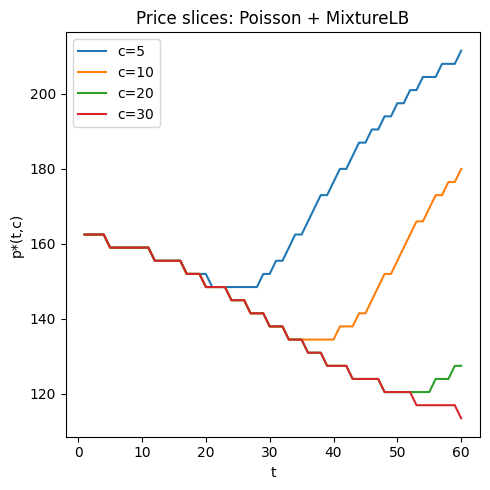

In [59]:
for (ak,wname),res in solns.items():
    plt.figure(figsize=(5,5))
    for c_pick in [5,10,20,30]:
        if c_pick<=C:
            plt.plot(range(1,T+1), res["P"][1:,c_pick], label=f"c={c_pick}")
    plt.xlabel("t")
    plt.ylabel("p*(t,c)")
    plt.title(f"Price slices: {ak} + {wname}")
    plt.legend()
    plt.tight_layout()
    plt.show()


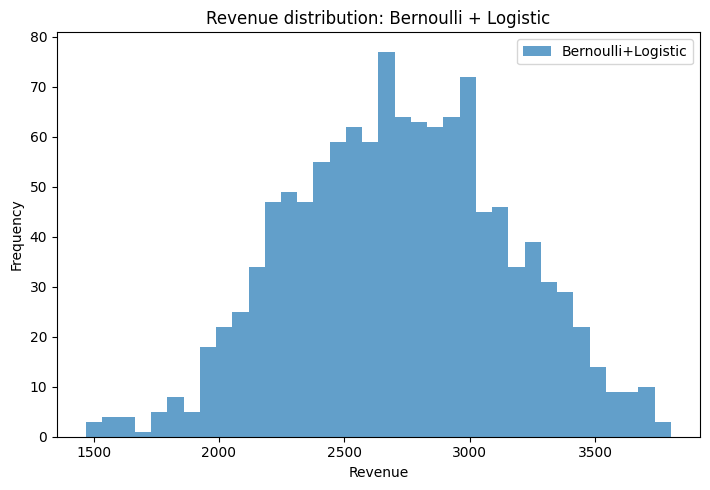

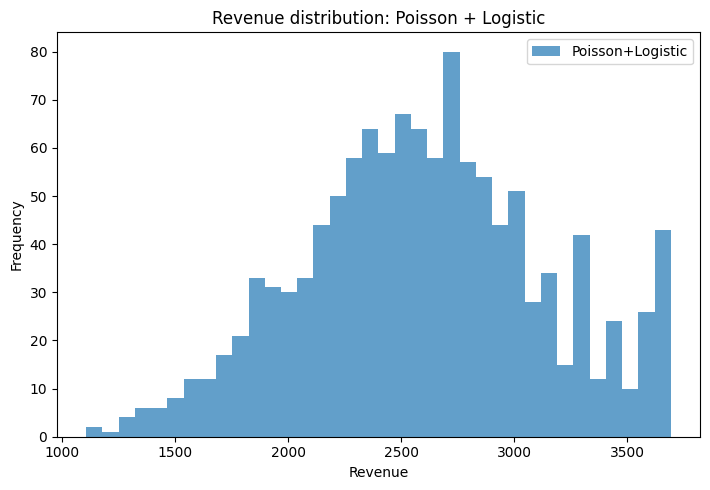

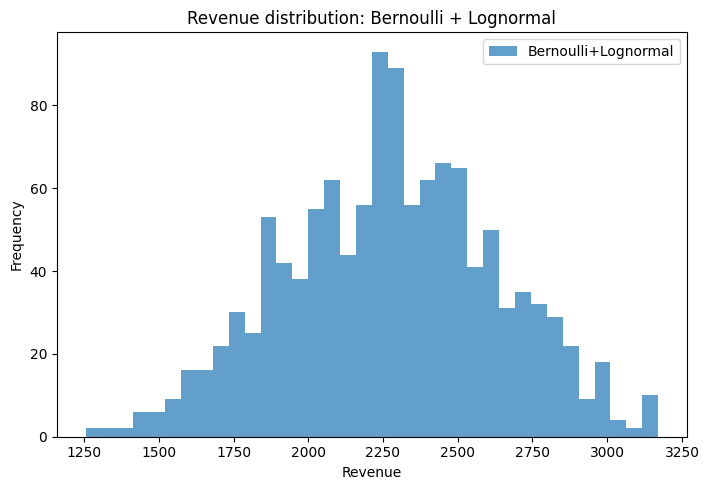

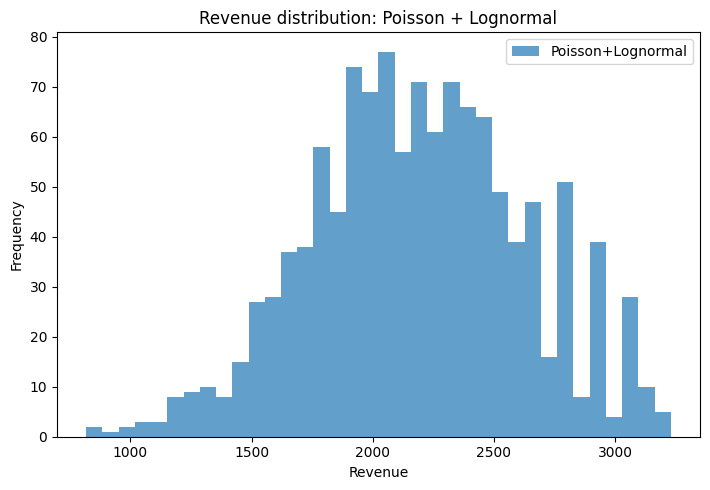

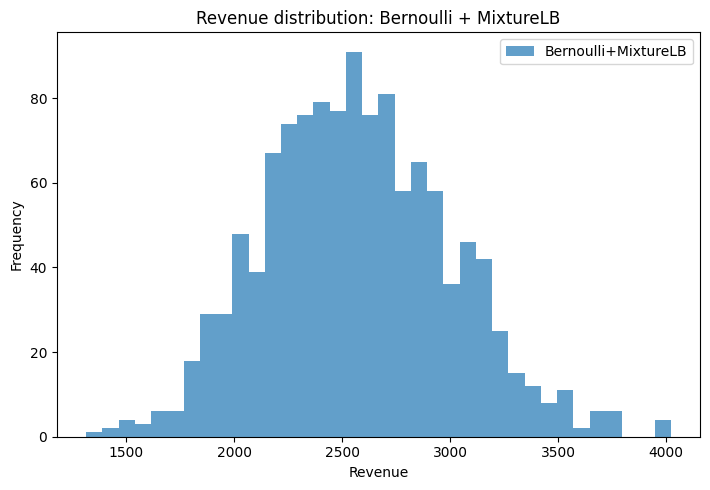

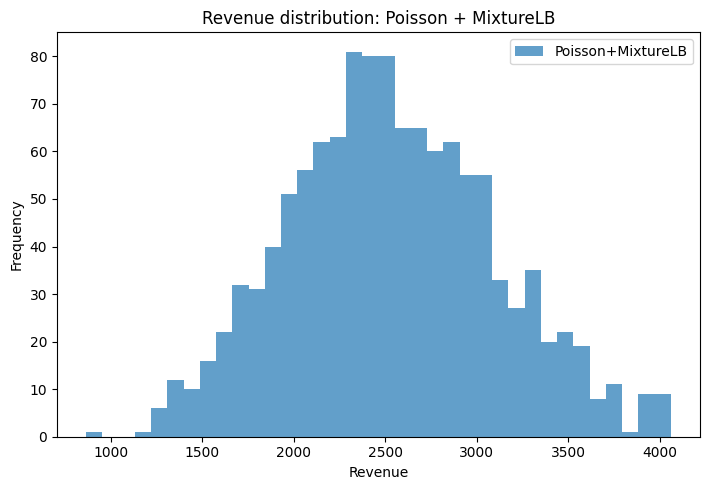

revenue       sold       left
('Bernoulli', 'Logistic')  mean  2721.056250  22.574167   7.425833
                           std    432.058729   3.337731   3.337731
('Poisson', 'Logistic')    mean  2596.234583  22.066667   7.933333
                           std    531.596281   4.302051   4.302051
('Bernoulli', 'Lognormal') mean  2276.567917  22.615000   7.385000
                           std    356.039410   3.267620   3.267620
('Poisson', 'Lognormal')   mean  2190.662500  22.122500   7.877500
                           std    443.149009   4.223825   4.223825
('Bernoulli', 'MixtureLB') mean  2569.954583  19.917500  10.082500
                           std    430.981544   3.226614   3.226614
('Poisson', 'MixtureLB')   mean  2532.644167  19.901667  10.098333
                           std    564.154391   4.306482   4.306482

In [60]:
def simulate_path(C, T, Pstar, arrival_kind, arrival_seq, sampler):
    c = C
    rev = 0.0
    sold = 0
    for t in range(T,0,-1):
        if c==0: break
        if arrival_kind=="bernoulli":
            if np.random.rand() < arrival_seq[t-1]:
                p = Pstar[t,c]
                w = sampler(t,T)
                if w>=p:
                    rev += p; sold += 1; c -= 1
        else:
            rate = float(arrival_seq[t-1])
            k = np.random.poisson(rate)
            if k==0: continue
            p = Pstar[t,c]
            if c==0: break
            ws = sampler(t,T,size=k)
            acc = (ws >= p).sum()
            x = int(min(acc, c))
            rev += x*p
            sold += x
            c -= x
    return dict(revenue=rev, sold=sold, left=c)

summaries = {}
for key,sc in scenarios.items():
    V,P = solns[key]["V"], solns[key]["P"]
    rows = []
    for _ in range(1200):
        out = simulate_path(C,T,P,sc["kind"],sc["arr"],sc["Sampler"])
        rows.append(out)
    df = pd.DataFrame(rows)
    summaries[key] = df.agg(['mean','std'])
    plt.figure(figsize=(7.2,5.0))
    plt.hist(df["revenue"], bins=36, alpha=0.7, label=f"{key[0]}+{key[1]}")
    plt.xlabel("Revenue")
    plt.ylabel("Frequency")
    plt.title(f"Revenue distribution: {key[0]} + {key[1]}")
    plt.legend()
    plt.tight_layout()
    plt.show()

pd.concat({str(k):v for k,v in summaries.items()}, axis=0)



/tmp/ipykernel_2237/4237655791.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data["DP"], data["EMSRa"], data["EMSRb"]], labels=["DP","EMSR-a","EMSR-b"])
/tmp/ipykernel_2237/4237655791.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data["DP"], data["EMSRa"], data["EMSRb"]], labels=["DP","EMSR-a","EMSR-b"])
/tmp/ipykernel_2237/4237655791.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data["DP"], data["EMSRa"], data["EMSRb"]], labels=["DP","EMSR-a","EMSR-b"])
/tmp/ipykernel_2237/4237655791.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() h

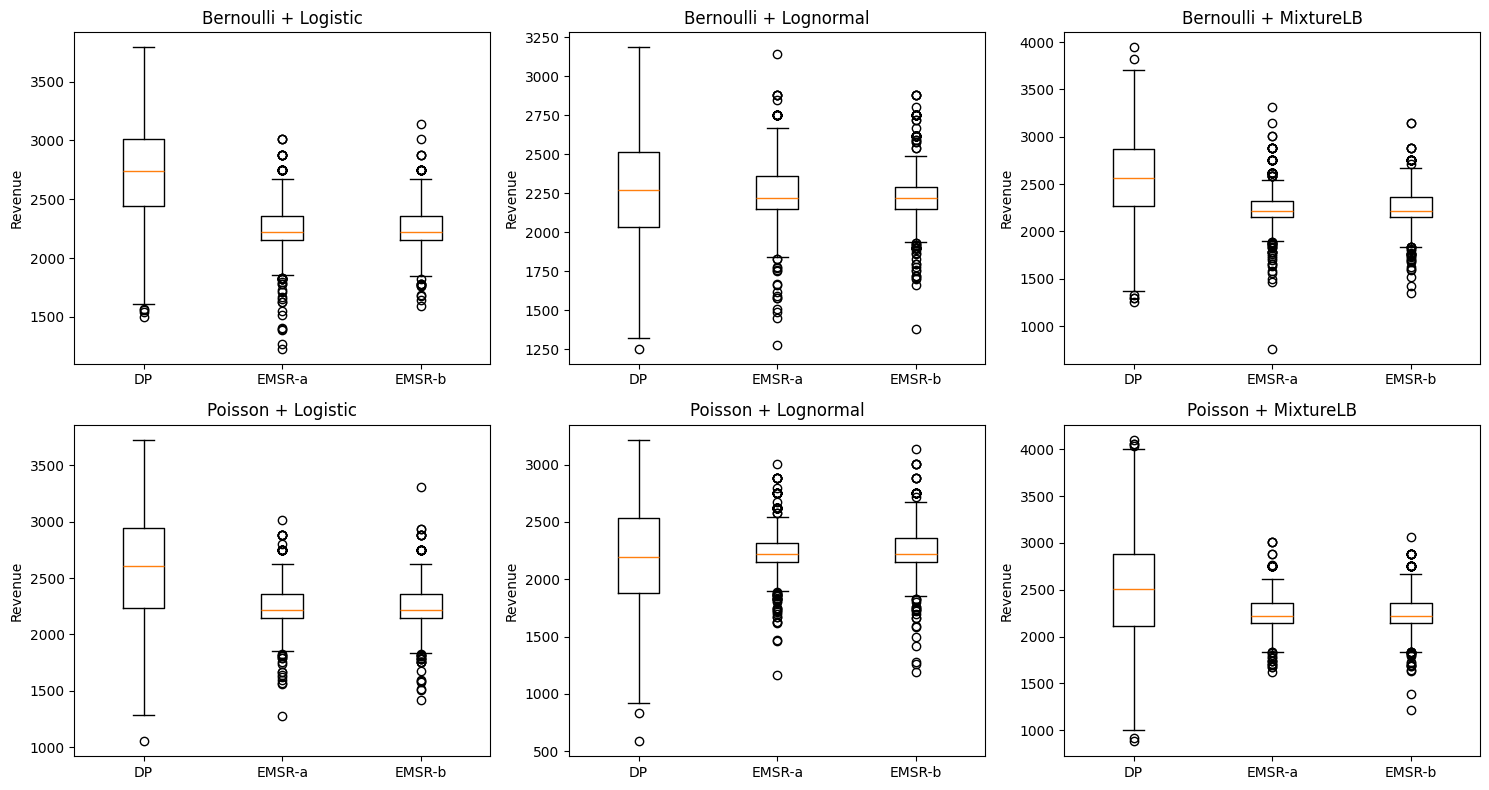

,Arrival,WTP,DP_mean,DP_std,EMSRa_mean,EMSRa_std,EMSRb_mean,EMSRb_std
0,Bernoulli,Logistic,2732.790000,421.918014,2248.158333,192.230829,2250.416667,171.278019
1,Bernoulli,Lognormal,2283.451250,339.492486,2247.683333,175.830789,2243.825000,166.899529
2,Bernoulli,MixtureLB,2568.739583,443.169518,2248.408333,187.556347,2248.975000,183.633329
3,Poisson,Logistic,2599.830417,520.264411,2254.641667,178.447111,2250.191667,185.309776
4,Poisson,Lognormal,2203.813333,454.927684,2245.225000,181.566194,2249.483333,188.878885
5,Poisson,MixtureLB,2508.996667,562.015909,2256.308333,179.286423,2254.650000,180.653105


In [61]:
import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
np.random.seed(42)

C = 30
T = 60
P_MIN, P_MAX, N_PRICES = 40.0, 320.0, 81
PRICE_GRID = np.linspace(P_MIN, P_MAX, N_PRICES)





def phi_inv(u):
    a1=-3.969683028665376e+01; a2=2.209460984245205e+02; a3=-2.759285104469687e+02
    a4=1.383577518672690e+02; a5=-3.066479806614716e+01; a6=2.506628277459239e+00
    b1=-5.447609879822406e+01; b2=1.615858368580409e+02; b3=-1.556989798598866e+02
    b4=6.680131188771972e+01; b5=-1.328068155288572e+01
    c1=-7.784894002430293e-03; c2=-3.223964580411365e-01; c3=-2.400758277161838e+00
    c4=-2.549732539343734e+00; c5=4.374664141464968e+00; c6=2.938163982698783e+00
    d1=7.784695709041462e-03; d2=3.224671290700398e-01; d3=2.445134137142996e+00
    d4=3.754408661907416e+00
    plow=0.02425; phigh=1-plow
    if u<plow:
        q=np.sqrt(-2*np.log(u)); return (((((c1*q+c2)*q+c3)*q+c4)*q+c5)*q+c6)/((((d1*q+d2)*q+d3)*q+d4)*1.0)
    if u>phigh:
        q=np.sqrt(-2*np.log(1-u)); return -(((((c1*q+c2)*q+c3)*q+c4)*q+c5)*q+c6)/((((d1*q+d2)*q+d3)*q+d4)*1.0)
    q=u-0.5; r=q*q
    return (((((a1*r+a2)*r+a3)*r+a4)*r+a5)*r+a6)*q/(((((b1*r+b2)*r+b3)*r+b4)*r+b5)*1.0+1e-12)

def nq(m,s,prob):
    prob=min(max(prob,1e-9),1-1e-9)
    return m + s*phi_inv(prob)

def emsr_a(classes, C):
    cls=sorted(classes,key=lambda z:-z.fare)
    n=len(cls)
    fares=np.array([z.fare for z in cls])
    mu=np.array([z.mu for z in cls])
    sigma=np.array([z.sigma for z in cls])
    y=np.zeros(n)
    for i in range(n-1):
        r_i=fares[i]
        s=0.0
        for j in range(i+1,n):
            r_j=fares[j]; q=1 - r_j/r_i
            s += max(0.0,nq(mu[j],sigma[j],q))
        y[i]=min(s,C)
    y[-1]=0.0
    bl=np.zeros(n)
    for k in range(n-1):
        bl[k+1]=max(0.0, C - y[k])
    bl[0]=C
    return dict(classes=cls, protection=y, booking_limits=bl)

def emsr_b(classes, C):
    cls=sorted(classes,key=lambda z:-z.fare)
    n=len(cls)
    fares=np.array([z.fare for z in cls])
    mu=np.array([z.mu for z in cls])
    sigma=np.array([z.sigma for z in cls])
    y=np.zeros(n)
    for i in range(n-1):
        r_i=fares[i]
        muL=mu[i+1:].sum()
        sigL=float(np.sqrt((sigma[i+1:]**2).sum())) if (n-(i+1))>0 else 0.0
        rbar=float(np.dot(fares[i+1:],mu[i+1:])/muL) if muL>0 else fares[-1]
        q=1 - rbar/r_i
        y[i]=max(0.0, min(C, nq(muL,sigL,q)))
    y[-1]=0.0
    bl=np.zeros(n)
    for k in range(n-1):
        bl[k+1]=max(0.0, C - y[k])
    bl[0]=C
    return dict(classes=cls, protection=y, booking_limits=bl)

classes = [type('x',(object,),{'fare':250.0,'mu':6.0,'sigma':2.0})(),
           type('x',(object,),{'fare':180.0,'mu':12.0,'sigma':3.0})(),
           type('x',(object,),{'fare':120.0,'mu':18.0,'sigma':4.0})(),
           type('x',(object,),{'fare':80.0,'mu':25.0,'sigma':5.0})()]

scale = A_target / sum([c.mu for c in classes])
for cobj in classes:
    cobj.mu *= scale

emsra = emsr_a(classes, C)
emsrb = emsr_b(classes, C)

def solve_dp(C,T,price_grid,arrival_kind,arrival_seq,surv_fn):
    V = np.zeros((T+1,C+1))
    Pstar = np.zeros((T+1,C+1))
    for t in range(1,T+1):
        if arrival_kind=="bernoulli":
            lam = float(arrival_seq[t-1])
        else:
            alpha = float(arrival_seq[t-1])
        for c in range(1,C+1):
            Vtm1c, Vtm1c1 = V[t-1,c], V[t-1,c-1]
            best, bp = -1e18, price_grid[0]
            for p in price_grid:
                S = surv_fn(p,t,T)
                if arrival_kind=="bernoulli":
                    val = (1-lam)*Vtm1c + lam*( S*(p+Vtm1c1) + (1-S)*Vtm1c )
                else:
                    rate = alpha
                    kmax = int(max(15, math.ceil(rate + 8*math.sqrt(rate+1e-9))))
                    pmf = [math.exp(-rate)]
                    for k in range(1, kmax+1):
                        pmf.append(pmf[-1]*rate/k)
                    val = 0.0
                    for k,pk in enumerate(pmf):
                        if pk<1e-12: continue
                        q = S
                        yy_prob = [math.comb(k,y)*(q**y)*((1-q)**(k-y)) for y in range(k+1)]
                        for y,py in enumerate(yy_prob):
                            x = y if y<=c else c
                            val += pk*py*( x*p + V[t-1, c-x] )
                if val>best:
                    best, bp = val, p
            V[t,c], Pstar[t,c] = best, bp
    return V, Pstar

def simulate_dp(policy_p, arrival_kind, arrival_seq, sampler, n_sims=800):
    rows = []
    for _ in range(n_sims):
        c = C
        rev = 0.0
        for t in range(T,0,-1):
            if c==0: break
            if arrival_kind=="bernoulli":
                if np.random.rand() < arrival_seq[t-1]:
                    p = policy_p[t,c]
                    w = sampler(t,T)
                    if w>=p:
                        rev += p; c -= 1
            else:
                k = np.random.poisson(arrival_seq[t-1])
                if k==0: continue
                p = policy_p[t,c]
                ws = sampler(t,T,size=k)
                acc = (ws >= p).sum()
                x = int(min(acc, c))
                rev += x*p
                c -= x
        rows.append(rev)
    return np.array(rows)

def simulate_emsr(emsr_out, classes, n_sims=800):
    rows=[]
    for _ in range(n_sims):
        total_demand = []
        for fc in classes:
            total_demand.append(np.random.poisson(fc.mu))
        sold=[0]*len(classes)
        remaining=C
        for i,fc in enumerate(emsr_out["classes"]):
            can_sell = max(0, int(min(remaining, emsr_out["booking_limits"][i] - sum(sold[:i]) if i>0 else remaining)))
            take = min(total_demand[i], can_sell)
            sold[i]=take
            remaining -= take
        revenue = sum([sold[i]*emsr_out["classes"][i].fare for i in range(len(classes))])
        rows.append(revenue)
    return np.array(rows)

wtp_families = {
    "Logistic": (S_logistic, sample_logistic),
    "Lognormal": (S_lognormal, sample_lognormal),
    "MixtureLB": (S_mixture_lb, sample_mixture_lb)
}

arrival_kinds = {
    "Bernoulli": lam_bern,
    "Poisson": alpha_pois
}

results = {}
n_sims = 1200

for ak, arr_seq in arrival_kinds.items():
    for wname, (S_fn, samp_fn) in wtp_families.items():
        V,P = solve_dp(C,T,PRICE_GRID, "bernoulli" if ak=="Bernoulli" else "poisson", arr_seq, S_fn)
        dp_revs = simulate_dp(P, ak.lower(), arr_seq, samp_fn, n_sims=n_sims)
        a_revs = simulate_emsr(emsra, classes, n_sims=n_sims)
        b_revs = simulate_emsr(emsrb, classes, n_sims=n_sims)
        results[(ak,wname)] = {"DP":dp_revs, "EMSRa":a_revs, "EMSRb":b_revs}

fig, axes = plt.subplots(2,3, figsize=(15,8))
for i,(ak,wname) in enumerate(results.keys()):
    row = 0 if ak=="Bernoulli" else 1
    col = ["Logistic","Lognormal","MixtureLB"].index(wname)
    ax = axes[row,col]
    data = results[(ak,wname)]
    ax.boxplot([data["DP"], data["EMSRa"], data["EMSRb"]], labels=["DP","EMSR-a","EMSR-b"])
    ax.set_title(f"{ak} + {wname}")
    ax.set_ylabel("Revenue")
plt.tight_layout()
plt.show()

summary_rows = []
for key,resdict in results.items():
    mean_dp = resdict["DP"].mean(); std_dp = resdict["DP"].std()
    mean_a = resdict["EMSRa"].mean(); std_a = resdict["EMSRa"].std()
    mean_b = resdict["EMSRb"].mean(); std_b = resdict["EMSRb"].std()
    summary_rows.append((key[0], key[1], mean_dp, std_dp, mean_a, std_a, mean_b, std_b))
summary_df = pd.DataFrame(summary_rows, columns=["Arrival","WTP","DP_mean","DP_std","EMSRa_mean","EMSRa_std","EMSRb_mean","EMSRb_std"])
display(summary_df)



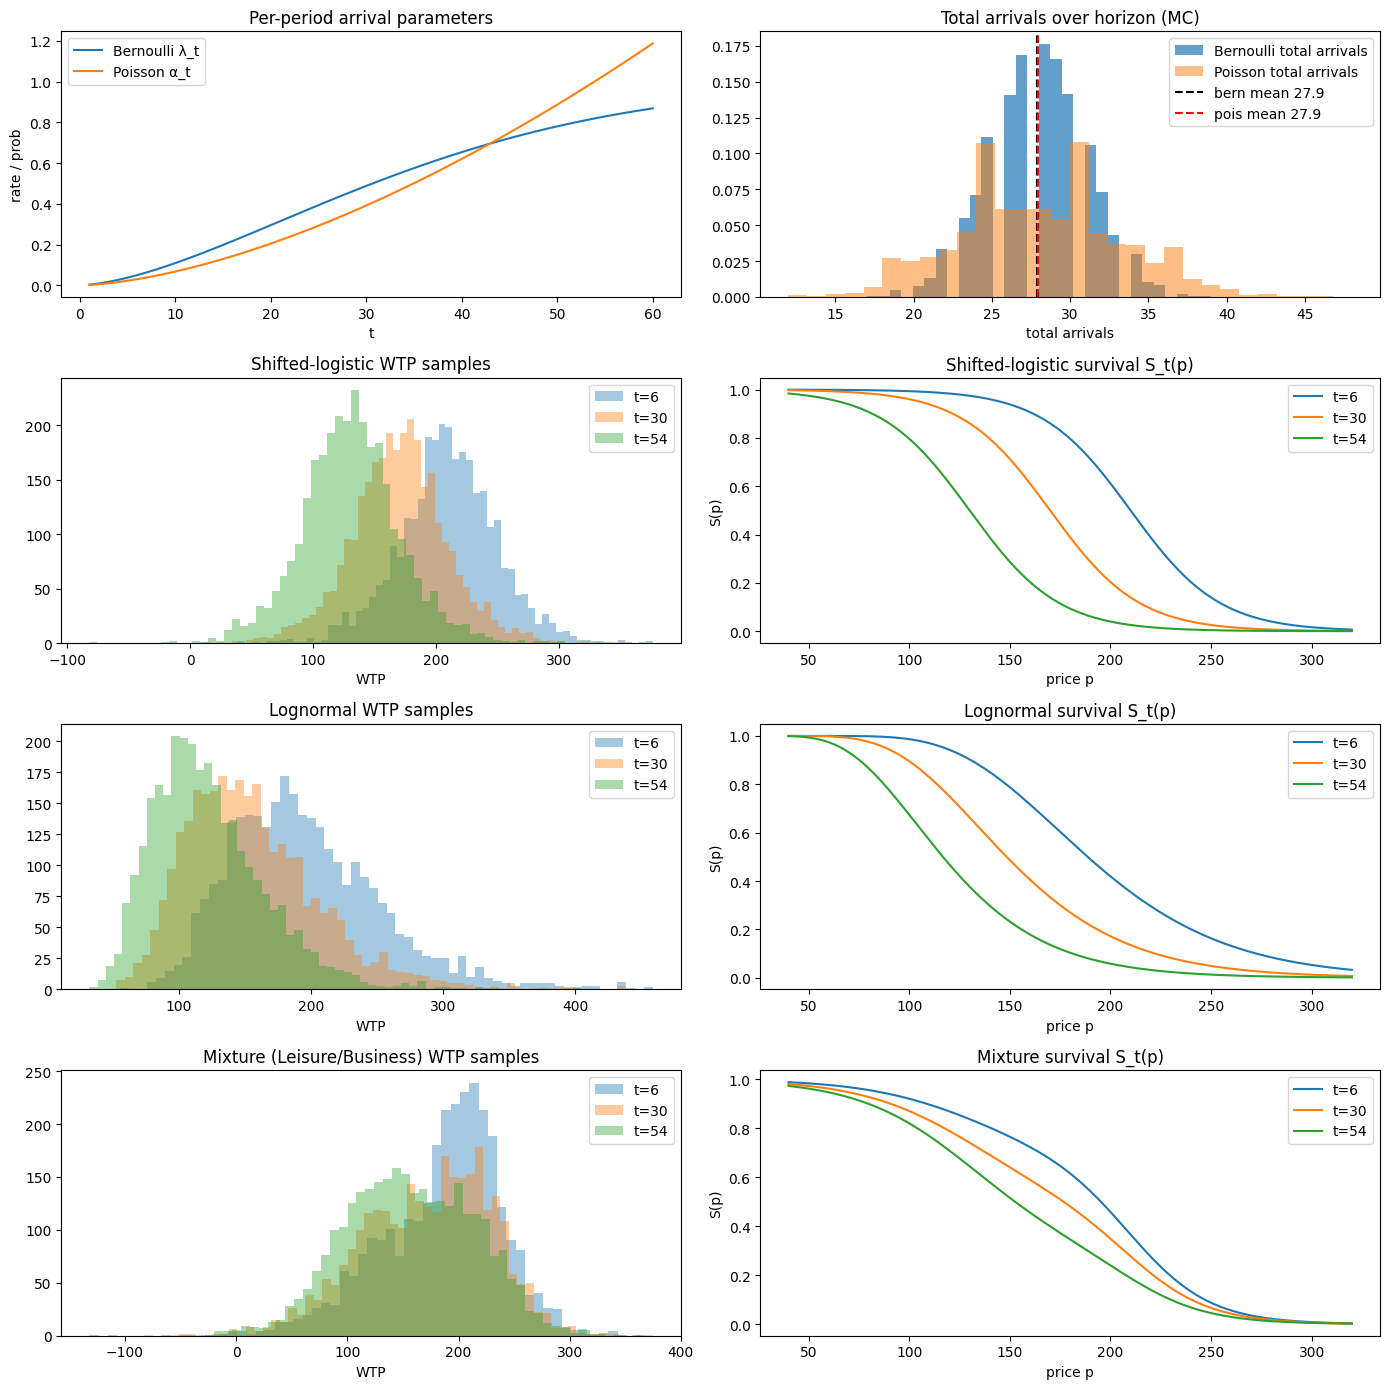

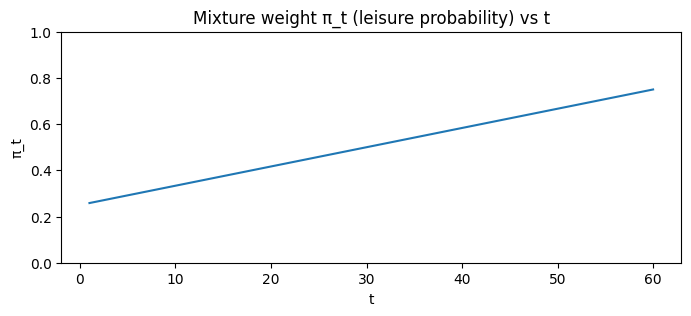

In [62]:
np.random.seed(0)

t_idx = np.arange(1, T+1)
prices = np.linspace(40, 320, 281)
t_samples = [max(1,int(T*0.1)), max(1,int(T*0.5)), max(1,int(T*0.9))]

fig = plt.figure(figsize=(14,14))

ax1 = plt.subplot2grid((4,4),(0,0), colspan=2)
ax2 = plt.subplot2grid((4,4),(0,2), colspan=2)
ax3 = plt.subplot2grid((4,4),(1,0), colspan=2)
ax4 = plt.subplot2grid((4,4),(1,2), colspan=2)
ax5 = plt.subplot2grid((4,4),(2,0), colspan=2)
ax6 = plt.subplot2grid((4,4),(2,2), colspan=2)
ax7 = plt.subplot2grid((4,4),(3,0), colspan=2)
ax8 = plt.subplot2grid((4,4),(3,2), colspan=2)

ax1.plot(t_idx, lam_bern, label='Bernoulli λ_t')
ax1.plot(t_idx, alpha_pois, label='Poisson α_t')
ax1.set_title("Per-period arrival parameters")
ax1.set_xlabel("t")
ax1.set_ylabel("rate / prob")
ax1.legend()

n_sims = 4000
bern_totals = np.sum(np.random.rand(n_sims, T) < lam_bern, axis=1)
pois_totals = np.sum(np.random.poisson(alpha_pois, size=(n_sims, T)), axis=1)
ax2.hist(bern_totals, bins=30, alpha=0.7, density=True, label='Bernoulli total arrivals')
ax2.hist(pois_totals, bins=30, alpha=0.5, density=True, label='Poisson total arrivals')
ax2.axvline(bern_totals.mean(), color='k', linestyle='--', label=f'bern mean {bern_totals.mean():.1f}')
ax2.axvline(pois_totals.mean(), color='r', linestyle='--', label=f'pois mean {pois_totals.mean():.1f}')
ax2.set_title("Total arrivals over horizon (MC)")
ax2.set_xlabel("total arrivals")
ax2.legend()

colors = ['C0','C1','C2']
for i,tt in enumerate(t_samples):
    s = sample_logistic(tt, T, size=3000)
    ax3.hist(s, bins=60, alpha=0.4, color=colors[i], label=f"t={tt}")
ax3.set_title("Shifted-logistic WTP samples")
ax3.set_xlabel("WTP")
ax3.legend()

for i,tt in enumerate(t_samples):
    surv = [S_logistic(p, tt, T) for p in prices]
    ax4.plot(prices, surv, color=colors[i], label=f"t={tt}")
ax4.set_title("Shifted-logistic survival S_t(p)")
ax4.set_xlabel("price p")
ax4.set_ylabel("S(p)")
ax4.legend()

for i,tt in enumerate(t_samples):
    s = sample_lognormal(tt, T, size=3000)
    ax5.hist(s, bins=60, alpha=0.4, color=colors[i], label=f"t={tt}")
ax5.set_title("Lognormal WTP samples")
ax5.set_xlabel("WTP")
ax5.legend()

for i,tt in enumerate(t_samples):
    surv = [S_lognormal(p, tt, T) for p in prices]
    ax6.plot(prices, surv, color=colors[i], label=f"t={tt}")
ax6.set_title("Lognormal survival S_t(p)")
ax6.set_xlabel("price p")
ax6.set_ylabel("S(p)")
ax6.legend()

for i,tt in enumerate(t_samples):
    s = sample_mixture_lb(tt, T, size=3000)
    ax7.hist(s, bins=60, alpha=0.4, color=colors[i], label=f"t={tt}")
ax7.set_title("Mixture (Leisure/Business) WTP samples")
ax7.set_xlabel("WTP")
ax7.legend()

for i,tt in enumerate(t_samples):
    surv = [S_mixture_lb(p, tt, T) for p in prices]
    ax8.plot(prices, surv, color=colors[i], label=f"t={tt}")
ax8.set_title("Mixture survival S_t(p)")
ax8.set_xlabel("price p")
ax8.set_ylabel("S(p)")
ax8.legend()

plt.tight_layout()
plt.show()

pi_vals = [ (0.75*(tt/T) + 0.25*(1-tt/T)) for tt in t_idx ]
plt.figure(figsize=(8,3))
plt.plot(t_idx, pi_vals)
plt.title("Mixture weight π_t (leisure probability) vs t")
plt.xlabel("t")
plt.ylabel("π_t")
plt.ylim(0,1)
plt.show()